In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# For my first CNN model
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# For the CNN model using VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Performancer Metric Analysis
from sklearn.metrics import classification_report

# Importing and Loading the Data

In [3]:
directory = "/Users/catherinesanso/Desktop/Github_Personal/speech-emotion-recognition/plots/spectograms"

# Create a generator for my training set
train = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),  # I might want this as 256, 256 if my results are bad. # Dont need to rescale bc all images are the same size
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

# Creating a generator for my validaton (=testing) set
test = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 10236 files belonging to 6 classes.
Using 8189 files for training.
Found 10236 files belonging to 6 classes.
Using 2047 files for validation.


In [5]:
# Confirming no class imbalance for my 6 target outputs
# If data is imbalanced, use class weights.

base_directory = "/Users/catherinesanso/Desktop/Github_Personal/speech-emotion-recognition/plots/spectograms"

image_counts = {}

# Iterate over subdirectories
for subfolder in os.listdir(base_directory):
    subfolder_path = os.path.join(base_directory, subfolder)
    if os.path.isdir(subfolder_path):
        # Count the number of files with .png extension in the subfolder
        num_images = len([filename for filename in os.listdir(subfolder_path) if filename.endswith('.png')])
        image_counts[subfolder] = num_images

# Print counts for each subfolder
for subfolder, count in image_counts.items():
    print(f"Subfolder '{subfolder}': {count} images")

Subfolder 'ANG': 1730 images
Subfolder 'NEU': 1530 images
Subfolder 'SAD': 1716 images
Subfolder 'HAP': 1860 images
Subfolder 'FEA': 1730 images
Subfolder 'DIS': 1670 images


---

# Creating the first CNN model:

In [6]:
# Instantiate the CNN model
cnn = Sequential()

# Add a convolutional layer
cnn.add(Conv2D(filters=32,
               kernel_size=(3,3),
               strides = (1,1), # to conform with padding
               padding = 'same',
               activation='relu',
               input_shape=(128, 128, 3),
               kernel_regularizer=l2(0.01)))

# Add a MaxPooling2D layer to downsample
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Add a second convolutional layer
cnn.add(Conv2D(filters=64,  # Increase the number of filters, base 2
               kernel_size=(3, 3),
               strides=(1, 1),
               padding='same',
               activation='relu',
               kernel_regularizer=l2(0.01)))

# Add a second MaxPooling2D layer to downsample
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the convolutional layer
cnn.add(Flatten())

# Add a dense layer: softmax activation for multi-class classification
cnn.add(Dense(units=6,
              activation='softmax',
              kernel_regularizer=l2(0.01)))

In [7]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 6)                 3

In [8]:
# Compile the model
cnn.compile(
    loss = 'sparse_categorical_crossentropy',
  optimizer = 'adam',
    metrics = ['accuracy'] 
)

In [9]:
# Add option for Early Stopping callback
early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=5,           # Number of epochs with no improvement after which training will stop
    restore_best_weights=True  # Restore the model weights from the epoch with the best validation loss
)

# Add option for ModelCheckpoint callback (to save the best model)
model_checkpoint = ModelCheckpoint(
    'best_cnn.h5',  # Filepath to save the best model
    monitor='val_accuracy', 
    save_best_only=True,  # Save only the best model
    verbose=1
)

In [20]:
# Fit the model
history = cnn.fit(train,
        validation_data = test,
        epochs = 25,
        batch_size = 64,
        callbacks = [early_stopping, model_checkpoint],
        verbose =1)

Epoch 1/15
256/256 [==============================] - ETA: 0s - loss: 1.4746 - accuracy: 0.5659
Epoch 1: val_accuracy did not improve from 0.95261
256/256 [==============================] - 31s 120ms/step - loss: 1.4746 - accuracy: 0.5659 - val_loss: 2.0897 - val_accuracy: 0.4118
Epoch 2/15
256/256 [==============================] - ETA: 0s - loss: 1.4265 - accuracy: 0.5926
Epoch 2: val_accuracy did not improve from 0.95261
256/256 [==============================] - 31s 121ms/step - loss: 1.4265 - accuracy: 0.5926 - val_loss: 1.9163 - val_accuracy: 0.4446
Epoch 3/15
256/256 [==============================] - ETA: 0s - loss: 1.3918 - accuracy: 0.6117
Epoch 3: val_accuracy did not improve from 0.95261
256/256 [==============================] - 32s 123ms/step - loss: 1.3918 - accuracy: 0.6117 - val_loss: 2.0316 - val_accuracy: 0.4641
Epoch 4/15
256/256 [==============================] - ETA: 0s - loss: 1.3544 - accuracy: 0.6257
Epoch 4: val_accuracy did not improve from 0.95261
256/256 [=

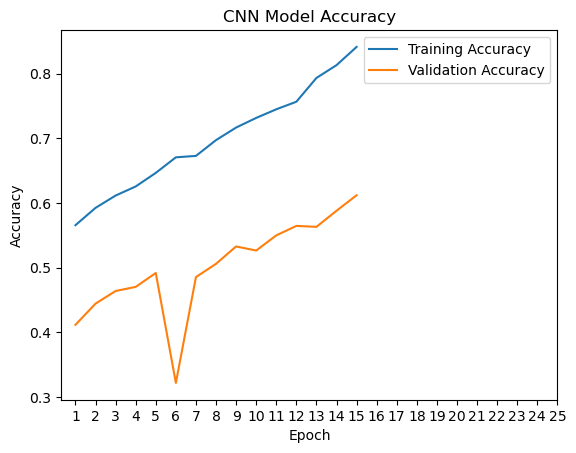

In [27]:
# Evaluate model history

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xticks(range(0,25), range(1,26))
plt.legend()
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

In [12]:
# Call preds
predictions = cnn.predict(test)

64/64 [==============================] - 3s 43ms/step


---

# Now using a VGG16 model with Transfer Learning

In [14]:
# Loading the pre-trained VGG16 model without the top classification layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [15]:
# Adding custom classification layers on top of VGG16 base:
# Because I need to format for my problem of multi-class with 6 target outputs

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(6, activation='softmax')(x)

In [16]:
# Creating the VGG-16 base model
vgg16_model = Model(inputs=base_model.input, outputs=output)

In [17]:
# Train the model

# Unfreeze some layers
for layer in base_model.layers[-4:]:
    layer.trainable = True
# I decided to make only the last 4 layers trainable for optimization

# Compile the model
vgg16_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Default learning rate is 0.001. Larger learning rate = model will converge faster = takes less time to learn, so better for optimization
    metrics=['accuracy']
)

In [18]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [19]:
# Add option for Early Stopping callback
early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=15,
    restore_best_weights=True
)

# Add option for ModelCheckpoint callback (to save the best model)
model_checkpoint = ModelCheckpoint(
    'best_vgg16.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    verbose=1
)

history = vgg16_model.fit(
    train,
    validation_data=test,
    epochs=25,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)

# Change learning rate to make it better
# Baseline Accuracy # is acc / # of classes so acc / 6 --> 100/6 =

Epoch 1/25
256/256 [==============================] - ETA: 0s - loss: 2.0396 - accuracy: 0.3060
Epoch 1: val_accuracy improved from -inf to 0.35320, saving model to best_vgg16.h5
256/256 [==============================] - 802s 3s/step - loss: 2.0396 - accuracy: 0.3060 - val_loss: 1.5721 - val_accuracy: 0.3532
Epoch 2/25
256/256 [==============================] - ETA: 0s - loss: 1.4630 - accuracy: 0.3968
Epoch 2: val_accuracy improved from 0.35320 to 0.39228, saving model to best_vgg16.h5
256/256 [==============================] - 812s 3s/step - loss: 1.4630 - accuracy: 0.3968 - val_loss: 1.4686 - val_accuracy: 0.3923
Epoch 3/25
256/256 [==============================] - ETA: 0s - loss: 1.3756 - accuracy: 0.4476
Epoch 3: val_accuracy improved from 0.39228 to 0.48412, saving model to best_vgg16.h5
256/256 [==============================] - 787s 3s/step - loss: 1.3756 - accuracy: 0.4476 - val_loss: 1.3164 - val_accuracy: 0.4841
Epoch 4/25
256/256 [==============================] - ETA: 0s

In [21]:
test_loss, test_accuracy = vgg16_model.evaluate(test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

64/64 [==============================] - 55s 851ms/step - loss: 0.3119 - accuracy: 0.9116
Test Loss: 0.3119
Test Accuracy: 91.16%


In [ ]:
# Shown in next notebook instead
# Load the best model saved by ModelCheckpoint
# best_vgg16 = tf.keras.models.load_model('best_vgg16.h5')

In [22]:
# Display the number of epochs used in the best model
best_model_epochs = len(history.history['val_accuracy'])
print("Number of epochs in the best model:", best_model_epochs)

Number of epochs in the best model: 15


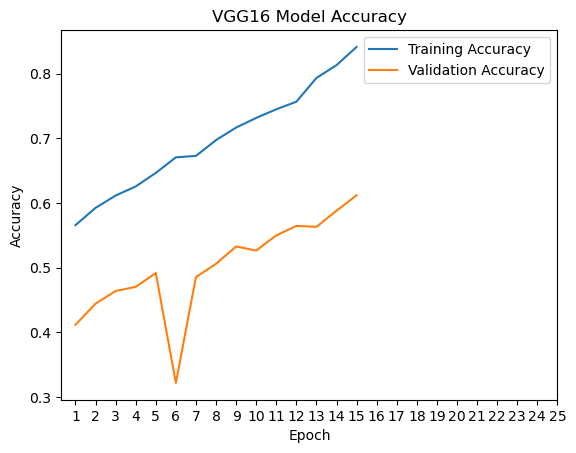

In [25]:
# Evaluate model history

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xticks(range(0,25), range(1,26))
plt.legend()
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

In [36]:
# Call preds
predictions = vgg16_model.predict(test)

64/64 [==============================] - 57s 882ms/step


### Generating a multi-class confusion matrix for the VGG16 model:

In [105]:
# Classification Matrix

target_names = ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']
print(classification_report(test, predictions, target_names=target_names))

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

ValueError: Found input variables with inconsistent numbers of samples: [64, 1]